# NB01: Study Overview

**Question:** What data do we have? What's broken? What's the rough performance landscape?

This notebook provides a high-level inventory of the `smart_retrieval_slm` study:
- Experiment health and completeness
- Coverage across models, datasets, agent types, and RAG components
- Overall performance landscape
- Metric correlation analysis (justifying F1 as primary metric)

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats

from analysis_utils import (
    load_all_results, setup_plotting, get_experiment_health_summary,
    print_search_space_summary, weighted_mean_with_ci,
    load_failed_experiments, analyze_failure_patterns,
    predict_context_length_issues,
    METRICS, PRIMARY_METRIC, MODEL_PARAMS, MODEL_TIER, BROKEN_MODELS,
    DATASET_COLORS, DATASET_MARKERS, DATASET_LABELS,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

df = load_all_results(STUDY_PATH)
print(f"Loaded {len(df)} experiments")


  343 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 314 exps — iterative
  Deduplicated: dropped 241 duplicate experiments (same effective config, kept best F1)
Loaded 749 experiments


## 1. Study Health

In [2]:
health = get_experiment_health_summary(STUDY_PATH)
print("Study Health")
print("=" * 50)
for k, v in health.items():
    print(f"  {k:<22s}: {v}")

# Check for missing metrics
print("\nMetric availability:")
for m in METRICS:
    if m in df.columns:
        n_valid = df[m].notna().sum()
        print(f"  {m:<15s}: {n_valid:>4d}/{len(df)} ({n_valid/len(df)*100:.0f}%)")

# Flag broken models
print("\nBroken models (near-zero F1):")
for model in sorted(BROKEN_MODELS):
    subset = df[df['model_short'] == model]
    if len(subset) > 0 and PRIMARY_METRIC in subset.columns:
        mean_f1 = subset[PRIMARY_METRIC].mean()
        print(f"  {model}: mean F1 = {mean_f1:.4f} ({len(subset)} experiments)")
    else:
        print(f"  {model}: no experiments loaded")

Study Health
  total_experiments     : 1035
  complete              : 990
  failed                : 6
  in_progress           : 32
  no_state              : 7

Metric availability:
  f1             :  749/749 (100%)
  exact_match    :  749/749 (100%)
  bertscore      :  749/749 (100%)
  bertscore_f1   :  106/749 (14%)
  bertscore_precision:  106/749 (14%)
  bertscore_recall:  106/749 (14%)
  bleurt         :  749/749 (100%)
  faithfulness   :   62/749 (8%)
  hallucination  :   62/749 (8%)
  answer_in_context:  695/749 (93%)
  context_recall :  695/749 (93%)

Broken models (near-zero F1):
  Phi-3-mini: mean F1 = 0.0168 (39 experiments)


## 1b. Experiment Failure Analysis

Which configurations crash? Are failures random or systematic?
Understanding failure patterns avoids wasting compute on doomed configs.

In [3]:
# Load failed experiments
failed_df = load_failed_experiments(STUDY_PATH)
n_failed = len(failed_df)
n_total = len(df) + n_failed
fail_rate = n_failed / n_total * 100 if n_total > 0 else 0

print(f"Experiment Failure Analysis")
print("=" * 60)
print(f"  Completed:  {len(df):>4d}")
print(f"  Failed:     {n_failed:>4d}")
print(f"  Total:      {n_total:>4d}")
print(f"  Fail rate:  {fail_rate:.1f}%")

if not failed_df.empty:
    patterns = analyze_failure_patterns(failed_df)

    # Error category breakdown
    print(f"\nError Categories:")
    if 'by_error_type' in patterns:
        for cat, count in patterns['by_error_type'].items():
            pct = count / n_failed * 100
            bar = '#' * int(pct / 2)
            print(f"  {cat:<25s}: {count:>3d} ({pct:.0f}%) {bar}")

    # Failure rate by model
    print(f"\nFailure Rate by Model:")
    if 'by_model' in patterns:
        model_counts = patterns['by_model']
        for model, fail_count in sorted(model_counts.items(), key=lambda x: -x[1]):
            total_model = len(df[df['model_short'] == model]) + fail_count
            rate = fail_count / total_model * 100 if total_model > 0 else 0
            print(f"  {model:<20s}: {fail_count:>3d} failed / {total_model:>3d} total ({rate:.0f}%)")

    # Failure rate by retriever
    print(f"\nFailure Rate by Retriever:")
    if 'by_retriever' in patterns:
        retr_counts = patterns['by_retriever']
        for retr, fail_count in sorted(retr_counts.items(), key=lambda x: -x[1]):
            total_retr = len(df[df['retriever_type'] == retr]) + fail_count
            rate = fail_count / total_retr * 100 if total_retr > 0 else 0
            print(f"  {retr:<20s}: {fail_count:>3d} failed / {total_retr:>3d} total ({rate:.0f}%)")

    # Visualization: failure heatmap (model x retriever)
    if 'model_short' in failed_df.columns and 'retriever_type' in failed_df.columns:
        fail_ct = pd.crosstab(failed_df['model_short'], failed_df['retriever_type'])
        if fail_ct.size > 1:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            sns.heatmap(fail_ct, annot=True, fmt='d', cmap='OrRd', ax=axes[0],
                        linewidths=0.5)
            axes[0].set_title('Failure Count: Model x Retriever')

            # Failure RATE heatmap (failures / total attempted)
            # Build total attempted from successes + failures
            success_ct = pd.crosstab(df['model_short'], df['retriever_type'])
            total_ct = success_ct.add(fail_ct, fill_value=0)
            rate_ct = fail_ct.div(total_ct).fillna(0) * 100
            sns.heatmap(rate_ct, annot=True, fmt='.0f', cmap='OrRd', ax=axes[1],
                        linewidths=0.5, vmin=0, vmax=100)
            axes[1].set_title('Failure Rate (%): Model x Retriever')

            plt.tight_layout()
            plt.show()

    # Context length risk prediction
    risky = predict_context_length_issues(STUDY_PATH)
    if isinstance(risky, pd.DataFrame) and not risky.empty:
        print(f"\nContext-Length Risk Predictions:")
        print(f"  {len(risky)} configurations flagged as high-risk")
        display(risky.head(10))
    else:
        print(f"\nContext-Length Risk: No high-risk configurations detected.")

    # Top-K and failure: do higher top_k values cause more failures?
    if 'top_k' in failed_df.columns and failed_df['top_k'].notna().sum() > 0:
        print(f"\nFailure Rate by Top-K:")
        for tk in sorted(failed_df['top_k'].dropna().unique()):
            tk_fail = len(failed_df[failed_df['top_k'] == tk])
            tk_success = len(df[df['top_k'] == tk]) if 'top_k' in df.columns else 0
            tk_total = tk_fail + tk_success
            rate = tk_fail / tk_total * 100 if tk_total > 0 else 0
            print(f"  top_k={int(tk):<4d}: {tk_fail:>3d} failed / {tk_total:>3d} total ({rate:.0f}%)")
else:
    print("\nNo failed experiments found — all experiments completed successfully.")

Experiment Failure Analysis
  Completed:   749
  Failed:        7
  Total:       756
  Fail rate:  0.9%

Error Categories:

Failure Rate by Model:
  unknown             :   7 failed /   7 total (100%)

Failure Rate by Retriever:
  dense               :   7 failed / 560 total (1%)

Context-Length Risk: No high-risk configurations detected.


## 2. Coverage

Search Space Summary
Total experiments: 749

  Experiment Type    ( 2): direct, rag
  Model              ( 8): Gemma2-2B, Gemma2-9B, Llama-3.2-3B, Mistral-7B, Phi-3-mini, Qwen2.5-1.5B, Qwen2.5-3B, Qwen2.5-7B
  Dataset            ( 3): hotpotqa, nq, triviaqa
  Retriever Type     ( 3): dense, hierarchical, hybrid
  Embedding Model    ( 3): BGE-M3, BGE-large, GTE-Qwen2-1.5B
  Top-K              ( 5): 10, 15, 20, 3, 5
  Query Transform    ( 4): hyde, iterative, multiquery, none
  Reranker           ( 3): bge, bge-v2, none
  Prompt             ( 9): concise, concise_json, concise_strict, cot, cot_final, extractive, extractive_quoted, fewshot_1, fewshot_3
  Agent Type         ( 4): direct_llm, fixed_rag, iterative_rag, self_rag
  Chunk Size         ( 2): 2048p/448c, 512


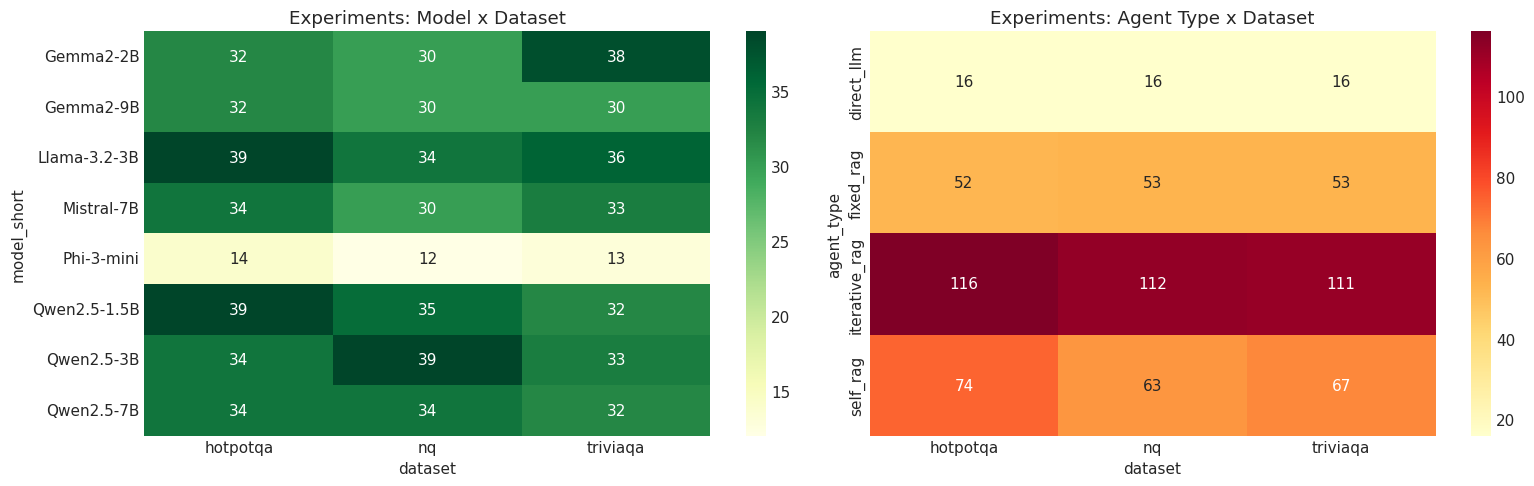

In [4]:
print_search_space_summary(df)

# Model x Dataset crosstab heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Model x Dataset
ct_model_ds = pd.crosstab(df['model_short'], df['dataset'])
sns.heatmap(ct_model_ds, annot=True, fmt='d', cmap='YlGn', ax=axes[0])
axes[0].set_title('Experiments: Model x Dataset')

# Agent type x Dataset
ct_agent_ds = pd.crosstab(df['agent_type'], df['dataset'])
sns.heatmap(ct_agent_ds, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Experiments: Agent Type x Dataset')

plt.tight_layout()
plt.show()

## 3. Performance Landscape

After filtering broken models: 710 experiments

Model Leaderboard (F1):


,model_short,mean,std,ci_low,ci_high,n,min,max
0,Gemma2-9B,0.397232,0.174055,0.373311,0.418135,92,0.034273,0.677749
1,Mistral-7B,0.340090,0.165953,0.313939,0.366934,97,0.029797,0.651555
2,Gemma2-2B,0.295959,0.156917,0.279068,0.310124,100,0.021103,0.571290
3,Llama-3.2-3B,0.272118,0.170391,0.244056,0.296490,109,0.017835,0.598895
4,Qwen2.5-3B,0.147289,0.113402,0.128911,0.164613,106,0.011951,0.390215
5,Qwen2.5-1.5B,0.133475,0.074076,0.122252,0.145646,106,0.011143,0.387065
6,Qwen2.5-7B,0.066395,0.052247,0.058227,0.074913,100,0.015806,0.250706


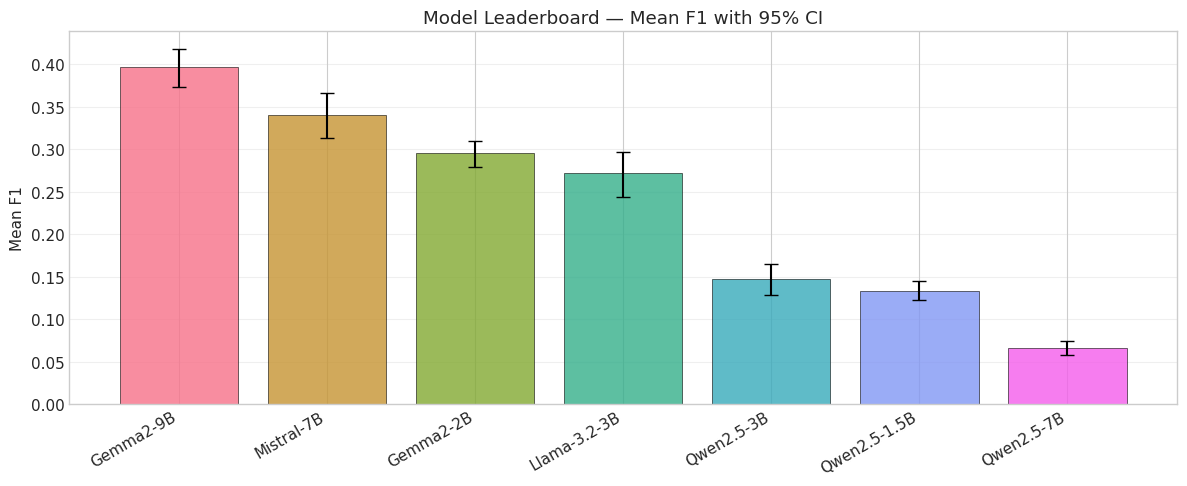

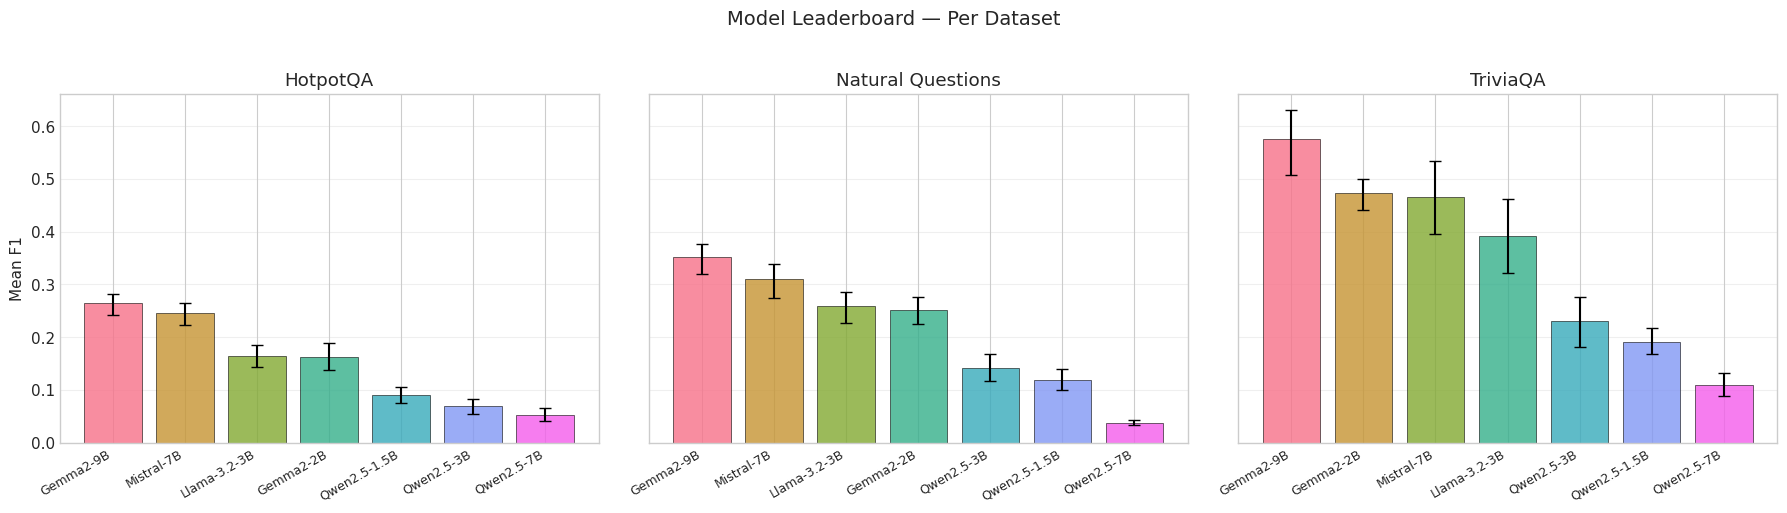

In [5]:
# Filter out broken models for performance analysis
df_clean = df[~df['model_short'].isin(BROKEN_MODELS)].copy()
print(f"After filtering broken models: {len(df_clean)} experiments")

# Model leaderboard
leaderboard = weighted_mean_with_ci(df_clean, 'model_short', PRIMARY_METRIC)
print("\nModel Leaderboard (F1):")
display(leaderboard)

# Bar chart with CI
fig, ax = plt.subplots(figsize=(12, 5))
x = range(len(leaderboard))
yerr_low = leaderboard['mean'] - leaderboard['ci_low']
yerr_high = leaderboard['ci_high'] - leaderboard['mean']
colors = [sns.color_palette('husl', len(leaderboard))[i] for i in range(len(leaderboard))]
ax.bar(x, leaderboard['mean'], yerr=[yerr_low, yerr_high], capsize=5,
       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(leaderboard['model_short'], rotation=30, ha='right')
ax.set_ylabel('Mean F1')
ax.set_title('Model Leaderboard — Mean F1 with 95% CI')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Per-dataset faceted model leaderboard ---
datasets = sorted(df_clean['dataset'].unique())
if len(datasets) >= 2:
    fig, axes_ds = plt.subplots(1, len(datasets),
                                figsize=(6 * len(datasets), 5), sharey=True)
    if len(datasets) == 1:
        axes_ds = [axes_ds]

    for ax_i, ds in zip(axes_ds, datasets):
        ds_df = df_clean[df_clean['dataset'] == ds]
        ds_lb = weighted_mean_with_ci(ds_df, 'model_short', PRIMARY_METRIC, stratify_by=None)
        if ds_lb.empty:
            ax_i.set_title(DATASET_LABELS.get(ds, ds))
            continue
        x_ds = range(len(ds_lb))
        yerr_lo = np.maximum(ds_lb['mean'] - ds_lb['ci_low'], 0)
        yerr_hi = np.maximum(ds_lb['ci_high'] - ds_lb['mean'], 0)
        ds_colors = [sns.color_palette('husl', len(ds_lb))[i] for i in range(len(ds_lb))]
        ax_i.bar(x_ds, ds_lb['mean'], yerr=[yerr_lo, yerr_hi], capsize=4,
                 color=ds_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        ax_i.set_xticks(list(x_ds))
        ax_i.set_xticklabels(ds_lb['model_short'], rotation=30, ha='right', fontsize=9)
        if ax_i == axes_ds[0]:
            ax_i.set_ylabel('Mean F1')
        ax_i.set_title(DATASET_LABELS.get(ds, ds))
        ax_i.grid(axis='y', alpha=0.3)

    fig.suptitle('Model Leaderboard — Per Dataset', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

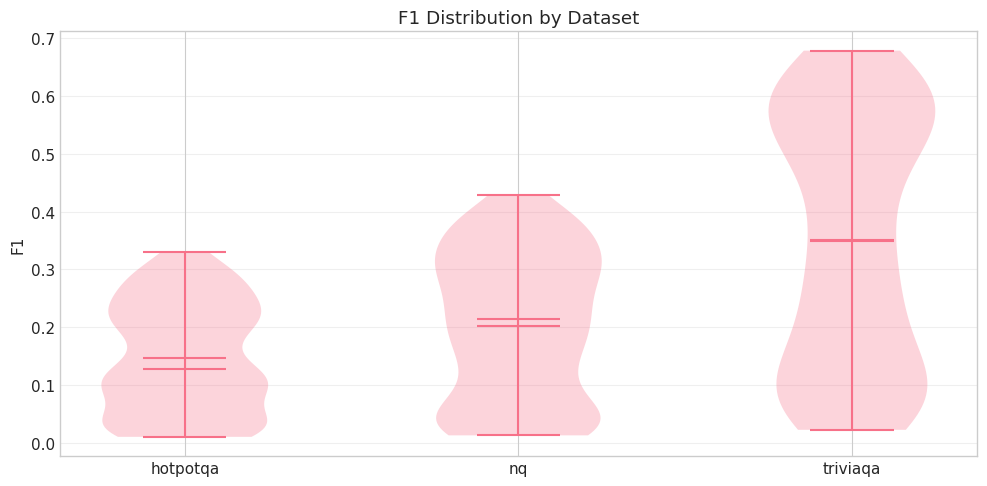

In [6]:
# Dataset violin plots of F1 distribution
fig, ax = plt.subplots(figsize=(10, 5))
datasets = sorted(df_clean['dataset'].unique())
data_for_violin = [df_clean[df_clean['dataset'] == ds][PRIMARY_METRIC].dropna().values
                   for ds in datasets]
parts = ax.violinplot(data_for_violin, showmeans=True, showmedians=True)
ax.set_xticks(range(1, len(datasets) + 1))
ax.set_xticklabels(datasets)
ax.set_ylabel('F1')
ax.set_title('F1 Distribution by Dataset')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Metric Correlation

Justification for using F1 as the primary metric: if F1, exact_match, bertscore, and bleurt are highly correlated, conclusions drawn from F1 generalize.

Metrics with sufficient data: ['f1', 'exact_match', 'bertscore', 'bertscore_f1', 'bertscore_precision', 'bertscore_recall', 'bleurt', 'faithfulness', 'hallucination', 'answer_in_context', 'context_recall']


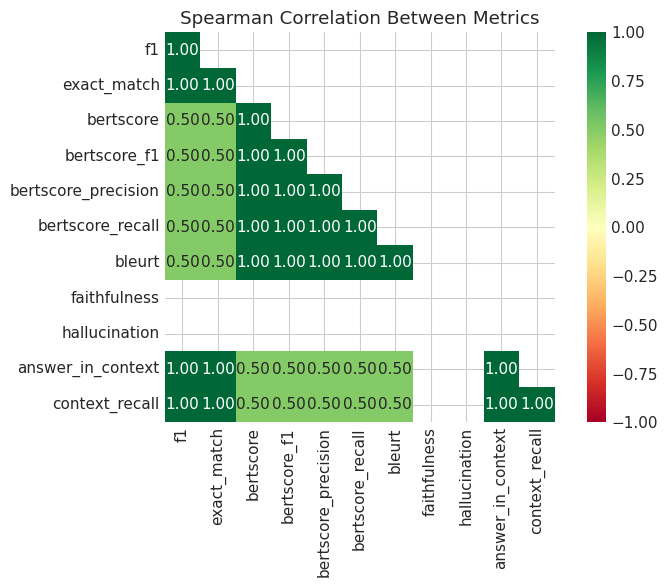


Correlation with F1:
  exact_match    : rho=1.000, p=0.00e+00
  bertscore      : rho=0.500, p=6.67e-01
  bertscore_f1   : rho=0.500, p=6.67e-01
  bertscore_precision: rho=0.500, p=6.67e-01
  bertscore_recall: rho=0.500, p=6.67e-01
  bleurt         : rho=0.500, p=6.67e-01
  faithfulness   : rho=nan, p=nan
  hallucination  : rho=nan, p=nan
  answer_in_context: rho=1.000, p=0.00e+00
  context_recall : rho=1.000, p=0.00e+00


In [7]:
# Compute Spearman correlations across all available metrics
available = [m for m in METRICS if m in df_clean.columns and df_clean[m].notna().sum() >= 10]
print(f"Metrics with sufficient data: {available}")

if len(available) >= 2:
    metric_df = df_clean[available].dropna()
    corr_matrix = metric_df.corr(method='spearman')

    fig, ax = plt.subplots(figsize=(8, 6))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
                vmin=-1, vmax=1, mask=mask, ax=ax, square=True)
    ax.set_title('Spearman Correlation Between Metrics')
    plt.tight_layout()
    plt.show()

    # Print pairwise correlations with F1
    print("\nCorrelation with F1:")
    for m in available:
        if m != PRIMARY_METRIC:
            rho, pval = scipy_stats.spearmanr(
                metric_df[PRIMARY_METRIC], metric_df[m]
            )
            print(f"  {m:<15s}: rho={rho:.3f}, p={pval:.2e}")
else:
    print("Not enough metrics with data for correlation analysis.")

## 5. Summary

Key takeaways from this overview — fill in after running on real data.

In [8]:
print("STUDY OVERVIEW SUMMARY")
print("=" * 60)
print(f"Total experiments (loaded):   {len(df)}")
print(f"After broken-model filter:    {len(df_clean)}")
print(f"Models:                       {sorted(df['model_short'].unique())}")
print(f"Datasets:                     {sorted(df['dataset'].unique())}")
print(f"Agent types:                  {sorted(df['agent_type'].unique())}")
print(f"Experiment types:             {df['exp_type'].value_counts().to_dict()}")
if PRIMARY_METRIC in df_clean.columns:
    print(f"\nOverall F1 (clean):  mean={df_clean[PRIMARY_METRIC].mean():.4f}, "
          f"std={df_clean[PRIMARY_METRIC].std():.4f}")

STUDY OVERVIEW SUMMARY
Total experiments (loaded):   749
After broken-model filter:    710
Models:                       ['Gemma2-2B', 'Gemma2-9B', 'Llama-3.2-3B', 'Mistral-7B', 'Phi-3-mini', 'Qwen2.5-1.5B', 'Qwen2.5-3B', 'Qwen2.5-7B']
Datasets:                     ['hotpotqa', 'nq', 'triviaqa']
Agent types:                  ['direct_llm', 'fixed_rag', 'iterative_rag', 'self_rag']
Experiment types:             {'rag': 701, 'direct': 48}

Overall F1 (clean):  mean=0.2327, std=0.1771
